## Extensions - Anomaly Detection Algorithm

### Exploring the train batch `batch146_17`

In [2]:
import pandas as pd
import seaborn as sns
df = pd.read_csv('~/cs645_project/data/clean/batch146_17_clean.csv')
df.head()
df.label.value_counts()

0    37967
1     5265
Name: label, dtype: int64

/Users/mm12574/miniconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='1_diff_avg_jvm_heap_used_value', ylabel='1_diff_driver_StreamingMetrics_streaming_totalReceivedRecords_value'>

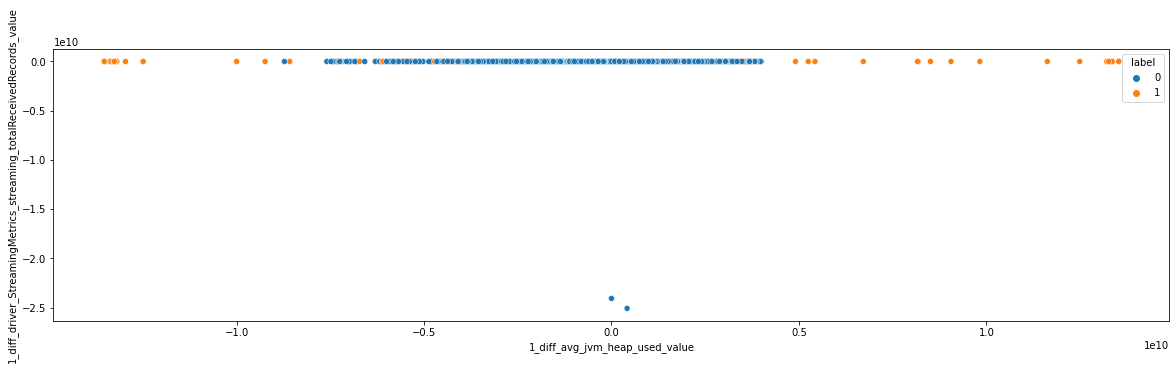

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.scatterplot(df['1_diff_avg_jvm_heap_used_value'],
                df['1_diff_driver_StreamingMetrics_streaming_totalReceivedRecords_value'],
                hue=df['label'])

### Preprocessing the data

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df.iloc[:, 1:-1]
y = df.label.values.ravel()
X_scaled = scaler.fit_transform(X)

In [5]:
# Train, test, validation split
# Unseen test set: 15%
# Validation set: (0.85*0.15) = 12.75%
# Train set 72.25%

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=9821)

print('Shape of X_test:', X_test.shape,';', 'Abnormal percentage:', round(sum(y_test)/len(y_test),3))
print('Shape of X_train:', X_train.shape,';', 'Abnormal percentage:', round(sum(y_train)/len(y_train),3))

Shape of X_test: (8647, 20) ; Abnormal percentage: 0.12
Shape of X_train: (34585, 20) ; Abnormal percentage: 0.122


### Model building

#### XGBoost

In [80]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score

xgb = XGBClassifier(use_label_encoder=False, random_state=9821, learning_rate=0.01)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('\n clasification report:\n', classification_report(y_test, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

[19:24:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9891291777495085
F1 score: 0.952952952952953
Recall: 0.9171483622350675
Precision: 0.9916666666666667

 clasification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7609
           1       0.99      0.92      0.95      1038

    accuracy                           0.99      8647
   macro avg       0.99      0.96      0.97      8647
weighted avg       0.99      0.99      0.99      8647


 confussion matrix:
 [[7601    8]
 [  86  952]]


#### Random forest

In [ ]:
"""
# Don't rerun, take a lot of time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier(random_state=9821)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
"""

In [73]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [82]:
# Use the best parameters to build the random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score
rf = RandomForestClassifier(random_state=9821)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('\n clasification report:\n', classification_report(y_test, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 0.9893604718399445
F1 score: 0.9542743538767395
Recall: 0.9248554913294798
Precision: 0.9856262833675564

 clasification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7609
           1       0.99      0.92      0.95      1038

    accuracy                           0.99      8647
   macro avg       0.99      0.96      0.97      8647
weighted avg       0.99      0.99      0.99      8647


 confussion matrix:
 [[7595   14]
 [  78  960]]


#### Neural Networks

In [29]:
from tensorflow import keras
model = keras.Sequential(
 [
 keras.layers.Dense(32, activation="relu", input_shape=(X_train.shape[-1],)),
 #keras.layers.BatchNormalization(),
 keras.layers.Dense(64, activation="relu"),
 keras.layers.Dropout(0.2),
 keras.layers.Dense(128, activation="relu"),
 keras.layers.BatchNormalization(),
 keras.layers.Dropout(0.2),
 keras.layers.Dense(1, activation="sigmoid"),
 ]
)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                672       
_________________________________________________________________
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                

In [54]:
import tensorflow.keras.backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(
 optimizer=keras.optimizers.Adam(1e-5),
 loss="binary_crossentropy",
 metrics=['accuracy']
)

history = model.fit(
 X_train,
 y_train,
 batch_size=128,
 epochs=10,
 verbose=2,
 validation_split = 0.2)

Epoch 1/10
217/217 - 1s - loss: 0.0411 - accuracy: 0.9864 - val_loss: 0.0542 - val_accuracy: 0.9809
Epoch 2/10
217/217 - 0s - loss: 0.0424 - accuracy: 0.9860 - val_loss: 0.0535 - val_accuracy: 0.9812
Epoch 3/10
217/217 - 0s - loss: 0.0413 - accuracy: 0.9851 - val_loss: 0.0534 - val_accuracy: 0.9816
Epoch 4/10
217/217 - 0s - loss: 0.0416 - accuracy: 0.9863 - val_loss: 0.0529 - val_accuracy: 0.9816
Epoch 5/10
217/217 - 0s - loss: 0.0416 - accuracy: 0.9860 - val_loss: 0.0531 - val_accuracy: 0.9812
Epoch 6/10
217/217 - 0s - loss: 0.0424 - accuracy: 0.9853 - val_loss: 0.0532 - val_accuracy: 0.9811
Epoch 7/10
217/217 - 0s - loss: 0.0397 - accuracy: 0.9863 - val_loss: 0.0525 - val_accuracy: 0.9815
Epoch 8/10
217/217 - 0s - loss: 0.0409 - accuracy: 0.9865 - val_loss: 0.0532 - val_accuracy: 0.9808
Epoch 9/10
217/217 - 0s - loss: 0.0399 - accuracy: 0.9868 - val_loss: 0.0527 - val_accuracy: 0.9811
Epoch 10/10
217/217 - 0s - loss: 0.0406 - accuracy: 0.9857 - val_loss: 0.0531 - val_accuracy: 0.9806

In [55]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score

y_pred = (model.predict(X_test)>0.5).astype('uint8')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('\n clasification report:\n', classification_report(y_test, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 0.9850815311668787
F1 score: 0.939521800281294
Recall: 0.9653179190751445
Precision: 0.915068493150685

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      7609
           1       0.92      0.97      0.94      1038

    accuracy                           0.99      8647
   macro avg       0.96      0.98      0.97      8647
weighted avg       0.99      0.99      0.99      8647


 confussion matrix:
 [[7516   93]
 [  36 1002]]
